In [1]:
import tensorflow as tf
import numpy as np
import time
from matplotlib import pyplot as plt
from keras import layers, datasets, models
from IPython import display
import os

2024-06-17 10:14:13.558775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 10:14:13.558928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 10:14:13.694011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(X_train, y_train),(X_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_data = np.concatenate((X_train, X_test), axis = 0)
train_labels = np.concatenate((y_train, y_test), axis = 0)

In [4]:
print(f"train_data.shape = {train_data.shape}")
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")

train_data.shape = (70000, 28, 28)
X_train.shape = (60000, 28, 28)
X_test.shape = (10000, 28, 28)


In [5]:
train_data = ( train_data -127.50 ) / 127.50


In [6]:
train_data.min()

-1.0

In [7]:
train_data.max()

1.0

In [8]:
batch_size = 256
buffer_size = train_data.shape[0]

batched_train_data = tf.data.Dataset.from_tensor_slices(train_data).shuffle(buffer_size).batch(batch_size)

In [9]:
len(batched_train_data)

274

In [10]:
# We can get above value by

train_data.shape[0]/batch_size

273.4375

## Generator

In [11]:
noise_dim = 100

def build_generator():
    model = models.Sequential(name='generator')
    
    model.add(layers.Dense(7 * 7 * 256, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU()) 
    
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding="same", kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (3, 3), padding="same", strides=(1, 1), activation="tanh"))
    
    return model

generator = build_generator()
generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,360,961 (9.01 MB)

 Trainable params: 2,335,425 (8.91 MB)

 Non-trainable params: 25,536 (99.75 KB)

In [12]:
input_shape = (28,28,1)

def build_discriminator():
    model = models.Sequential(name='discriminator')
    
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(layers.BatchNormalization(momentum=0.7))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization(momentum=0.7))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same", kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization(momentum=0.7))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.MaxPool2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,481 (1.42 MB)

 Trainable params: 371,585 (1.42 MB)

 Non-trainable params: 896 (3.50 KB)

## Testing

tf.Tensor([[0.52765495]], shape=(1, 1), dtype=float32)


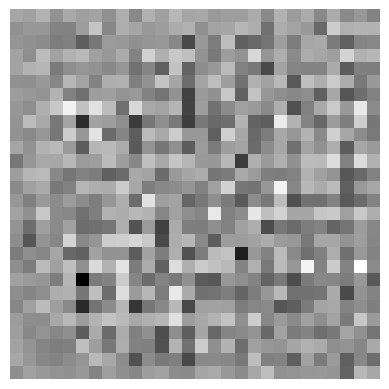

In [13]:
num_samples = 1
noises = tf.random.normal([num_samples, noise_dim])
gen_img = generator(noises, training = False)
plt.imshow(gen_img[0,:,:,0], cmap = 'gray')
plt.axis('off')
print(discriminator(gen_img))
plt.show()

## Optimizer

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5)

## Loss Function

In [15]:
mse = tf.keras.losses.MeanSquaredError()

In [16]:
def generator_loss (predictions):
  return mse(tf.ones_like(predictions),predictions)

In [17]:
def discriminator_loss(real_output, fake_output):
    
    # Apply label smoothing to real and fake labels
    real_labels = tf.random.uniform(shape=tf.shape(real_output), minval=0.85, maxval=1.0)
    fake_labels = tf.random.uniform(shape=tf.shape(fake_output), minval=0.0, maxval=0.15)
    
    real_loss = mse(real_labels, real_output)
    fake_loss = mse(fake_labels, fake_output)

    total_loss = real_loss + fake_loss
    
    return total_loss

## Training

In [18]:
noise_dim = noise_dim
batch_size = batch_size

print(f"batch_size = {batch_size}")
print(f"noise_dim = {noise_dim}")


batch_size = 256
noise_dim = 100


In [19]:
@tf.function


def train_step (real_images):
  
  noise = tf.random.normal([batch_size, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)
    
    fake_outputs = discriminator(generated_images, training  = True)
    
    real_outputs = discriminator(real_images, training = True)
    
    gen_loss = generator_loss(fake_outputs)
    disc_loss = discriminator_loss(real_output = real_outputs, fake_output = fake_outputs)
    
  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
  
  return disc_loss, gen_loss
    

In [20]:
# Test generator on following noises throughout training
num_samples = 16
test_noises = tf.random.normal([num_samples,noise_dim])

In [21]:
def generate_and_save_image(model, epoch, test_input):
    rows = 4
    cols = 4
    
    plt.figure(figsize=(rows*2, cols*2))
    plt.suptitle(f"Epoch = {epoch}")
    
    generated_images = model(test_input)
    
    for i in range(rows * cols):
        ax = plt.subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    
    plt.tight_layout()  
    
    if not os.path.exists("images"):
        os.makedirs("images")
    
    plt.savefig(f"images/image-at-epoch-{epoch:04d}.png") 
    plt.show()


In [22]:
# Define checkpoint directory and checkpoint prefix
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


# Restore the latest checkpoint if available
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print("Checkpoint restored:", latest_checkpoint)

In [23]:
def train(dataset, epochs):
    disc_losses = []
    gen_losses = []

    for epoch in range(1, epochs + 1):
        start = time.time()

        for real_image_batch in dataset:
            disc_loss, gen_loss = train_step(real_image_batch)
        
        disc_losses.append(disc_loss)
        gen_losses.append(gen_loss)
        
        display.clear_output(wait=True)
        print(f"Epoch = {epoch}, disc_loss = {disc_loss}, gen_loss = {gen_loss}, time_taken = {time.time() - start} seconds")
        generate_and_save_image(model=generator, epoch=epoch, test_input=test_noises)

        if epoch % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"checkpoint saved for epoch = {epoch}")

        history = {
            'discriminator_losses': disc_losses,
            'generator_losses': gen_losses
        }

        print(f"history of epoch = {epoch} saved")
        
        print(f"epoch = {epoch+1} started")
    
    return history

Epoch = 50, disc_loss = 0.21128681302070618, gen_loss = 0.44804877042770386, time_taken = 14.710025787353516 seconds


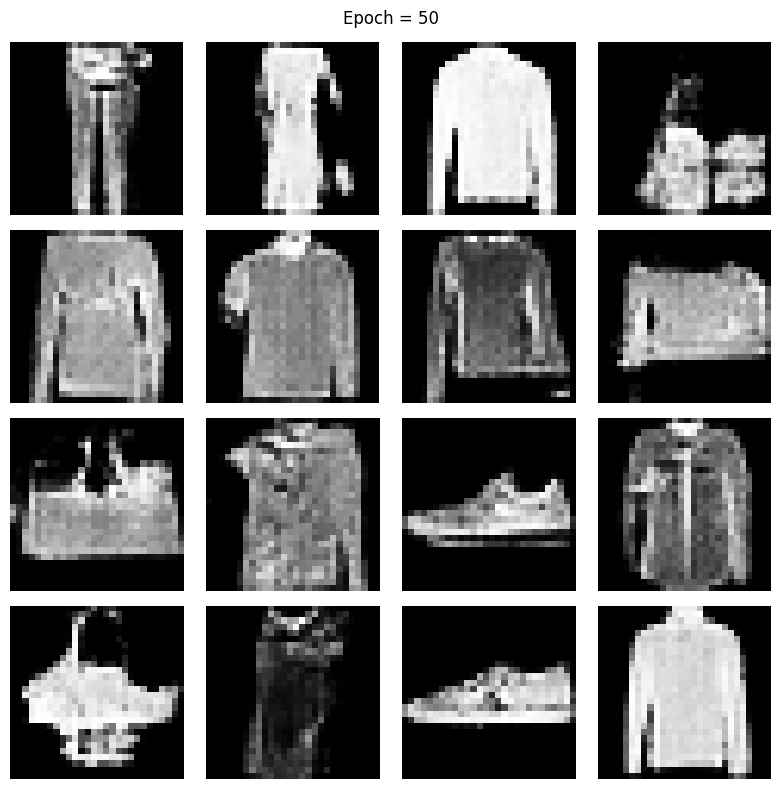

checkpoint saved for epoch = 50
history of epoch = 50 saved
epoch = 51 started


In [24]:
epochs = 50
history = train(batched_train_data, epochs = epochs)

In [30]:
import pickle

# Ensure the output directory exists
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Save the history object to the output directory
output_path = os.path.join(output_dir, 'dcgan-fashion-mnist-mse-history-before-modification.pkl')
with open(output_path, 'wb') as pickle_file:
    pickle.dump(history, pickle_file)

In [31]:
# Load the history from the pickle file
with open('dcgan-fashion-mnist-mse-history-before-modification.pkl', 'rb') as pickle_file:
    loaded_history_pickle = pickle.load(pickle_file)

# Access the loaded history
discriminator_losses = loaded_history_pickle['discriminator_losses']
generator_losses = loaded_history_pickle['generator_losses']

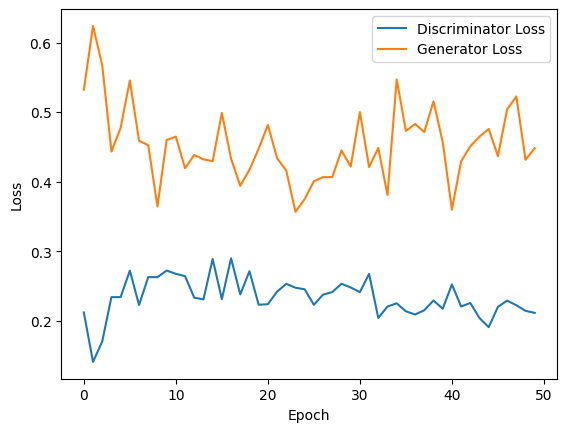

In [32]:
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
generator.save("generator-dcgan-fashion-mnist-mse-before-modification.h5")

In [34]:
import shutil

# Define the directory containing the images and the output zip file
images_dir = '/kaggle/working/images'
output_zip = '/kaggle/working/images-fashion-mnist-mse-before-modification.zip'

# Zip the directory
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', images_dir)

print(f"Zipped {images_dir} to {output_zip}")


Zipped /kaggle/working/images to /kaggle/working/images-fashion-mnist-mse-before-modification.zip
